In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pyspark as ps
import pyspark.sql.functions as f
from pyspark.sql.functions import col
from math import exp
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, FloatType, IntegerType
plt.style.use('seaborn')

from src.functions import *

In [3]:
df = pd.read_csv('data/movies.csv')

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df[df.genre == 'Horror'].description[435], df[df.genre == 'Horror'].original_title[435]

('A mad, disfigured composer seeks love with a lovely young opera singer.',
 'The Phantom of the Opera')

In [7]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('Capstone')
         .getOrCreate()
        )
sc = spark.sparkContext

In [8]:
cpiLookup_udf = udf(cpiLookup, DoubleType())

In [9]:
cpiAdjustedVal_udf = udf(cpiAdjustedVal, DoubleType())

In [10]:
# read CSV
df = spark.read.csv('data/movies.csv',
                    header=True,       # use headers or not
                    inferSchema=True )  # do we infer schema or not ?

# prints the schema
df.printSchema()

# some functions are still valid
#print(f'line count: {df.count()}')
all_df = df.select('imdb_title_id', 'original_title', 'genre','year', 'production_company', 'country','director','actors', 'budget', 'worlwide_gross_income', 'metascore')\
                         .where((df.year > 1927) & (df.budget.isNotNull() == True) & (df.worlwide_gross_income.isNotNull() == True))\

all_df = all_df.withColumn('budget', f.regexp_replace('budget', '[$,]', '').cast('int'))\
               .withColumn('year',col('year').cast('int'))\
               .withColumn('worlwide_gross_income', f.regexp_replace('worlwide_gross_income', '[$]','').cast('float'))
all_df = all_df.where((all_df.budget.isNotNull() == True) & (all_df.worlwide_gross_income.isNotNull() == True))
all_df.where((all_df.original_title.rlike('Titanic')) & (all_df.actors.rlike('Leo'))).show()
all_df = all_df.withColumn("cpi",cpiLookup_udf('year'))
all_df = all_df.withColumn("adjusted_budget", cpiAdjustedVal_udf('cpi', 'budget'))
all_df = all_df.withColumn("adjusted_worlwide_gross_income", cpiAdjustedVal_udf('cpi', 'worlwide_gross_income'))
contest_df = all_df.where((all_df.adjusted_budget > 1e5))
american_budget_df = all_df.where((all_df.year >= 1978) & (all_df.country.rlike('USA')))

root
 |-- imdb_title_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- year: string (nullable = true)
 |-- date_published: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- language: string (nullable = true)
 |-- director: string (nullable = true)
 |-- writer: string (nullable = true)
 |-- production_company: string (nullable = true)
 |-- actors: string (nullable = true)
 |-- description: string (nullable = true)
 |-- avg_vote: string (nullable = true)
 |-- votes: string (nullable = true)
 |-- budget: string (nullable = true)
 |-- usa_gross_income: string (nullable = true)
 |-- worlwide_gross_income: string (nullable = true)
 |-- metascore: string (nullable = true)
 |-- reviews_from_users: string (nullable = true)
 |-- reviews_from_critics: string (nullable = true)

+-------------+--------------+--------------+----+---------

In [11]:
american_budget_df.toPandas()

,imdb_title_id,original_title,genre,year,production_company,country,director,actors,budget,worlwide_gross_income,metascore,cpi,adjusted_budget,adjusted_worlwide_gross_income
0,tt0035423,Kate & Leopold,"Comedy, Fantasy, Romance",2001,Konrad Pictures,USA,James Mangold,"Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...",48000000,76019048.0,44.0,177.1,7.060418e+07,1.118180e+08
1,tt0076263,Killer of Sheep,Drama,1978,None,USA,Charles Burnett,"Henry G. Sanders, Kaycee Moore, Charles Bracy,...",100000,468460.0,96.0,65.2,3.995399e+05,1.871685e+06
2,tt0077233,The Big Fix,"Comedy, Mystery, Thriller",1978,Universal Pictures,USA,Jeremy Kagan,"Richard Dreyfuss, Susan Anspach, Bonnie Bedeli...",3800000,13062708.0,None,65.2,1.518252e+07,5.219073e+07
3,tt0077248,Blue Collar,"Crime, Drama",1978,TAT Communications Company,USA,Paul Schrader,"Richard Pryor, Harvey Keitel, Yaphet Kotto, Ed...",1700000,6521083.0,77.0,65.2,6.792178e+06,2.605433e+07
4,tt0077275,The Brink's Job,"Comedy, Crime, Drama",1978,Dino De Laurentiis Company,USA,William Friedkin,"Peter Falk, Peter Boyle, Allen Garfield, Warre...",15500000,7909950.0,None,65.2,6.192868e+07,3.160340e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6875,tt9134216,Playing with Fire,"Comedy, Family",2019,Broken Road Productions,USA,Andy Fickman,"John Cena, Keegan-Michael Key, John Leguizamo,...",29900000,68631672.0,24.0,257.0,3.030720e+07,6.956634e+07
6876,tt9173418,Brahms: The Boy II,"Drama, Horror, Mystery",2020,STX Films,"USA, China, Canada, Australia",William Brent Bell,"Katie Holmes, Christopher Convery, Owain Yeoma...",10000000,20311536.0,29.0,260.5,1.000000e+07,2.031154e+07
6877,tt9208444,Impractical Jokers: The Movie,Comedy,2020,Funny or Die,USA,Chris Henchy,"Paula Abdul, Joe Gatto, James Murray, Brian Qu...",3000000,10691091.0,39.0,260.5,3.000000e+06,1.069109e+07
6878,tt9354944,Jexi,"Comedy, Romance",2019,CBS Films,"USA, Canada","Jon Lucas, Scott Moore","Adam Devine, Alexandra Shipp, Rose Byrne, Ron ...",5000000,9341824.0,39.0,257.0,5.068093e+06,9.469047e+06


(0, [-18629420.39767694, 135261024.55920392], 60607326.669296935)

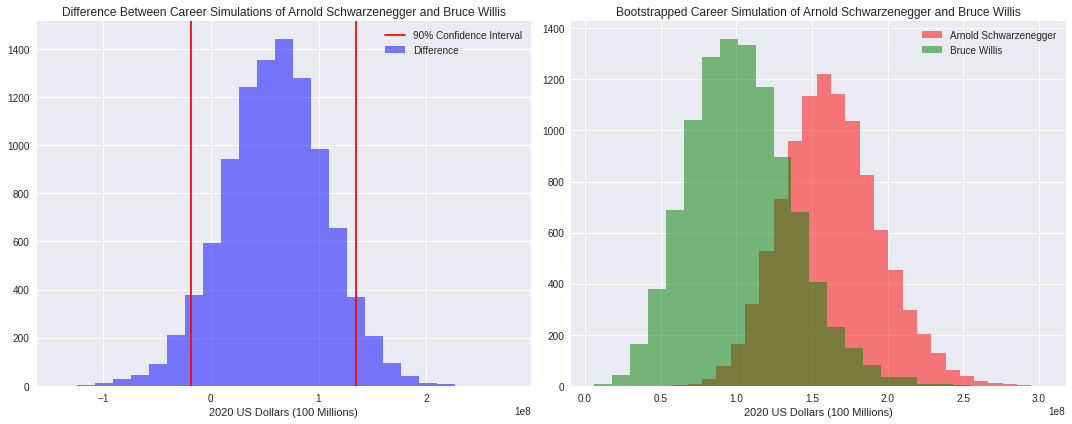

In [12]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
compare_actors_net(american_budget_df, 'Arnold Schwarzenegger', 'Bruce Willis', ax)

(1, [52050365.82145676, 551685795.9902407], 280451870.6240691)

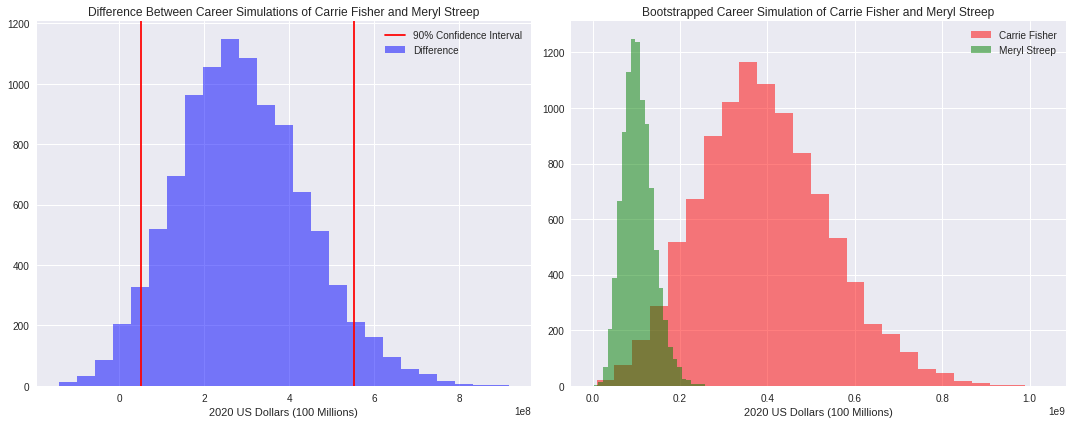

In [13]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
compare_actors_net(american_budget_df, 'Carrie Fisher','Meryl Streep', ax)

(1, [82798330.52589107, 171738802.7220002], 126733628.64148471)

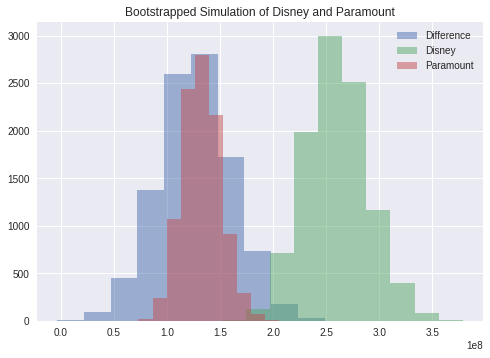

In [14]:
compare_studios_net(american_budget_df,'Disney', 'Paramount')

(-1, [-92659186.88079318, -67946403.2686866], -79982753.80362624)

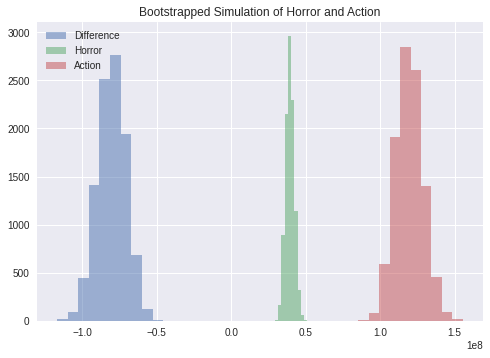

In [15]:
compare_genre_net(american_budget_df,'Horror', 'Action')

(0, [-1.8933112650105204, 2.1914462289088035], 0.4208164938827417)

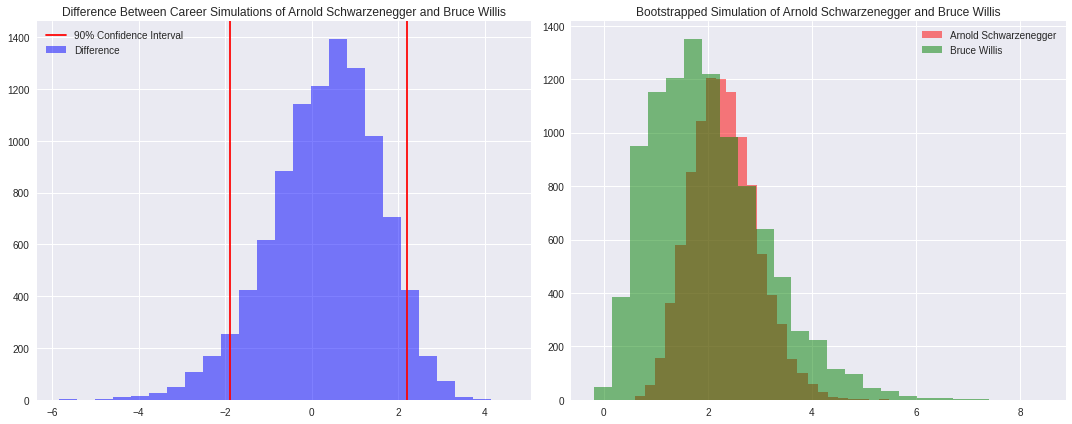

In [16]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
compare_actors_roi(contest_df, 'Arnold Schwarzenegger', 'Bruce Willis', ax)

(1, [0.30308058159538814, 12.466963184392506], 5.244300324509275)

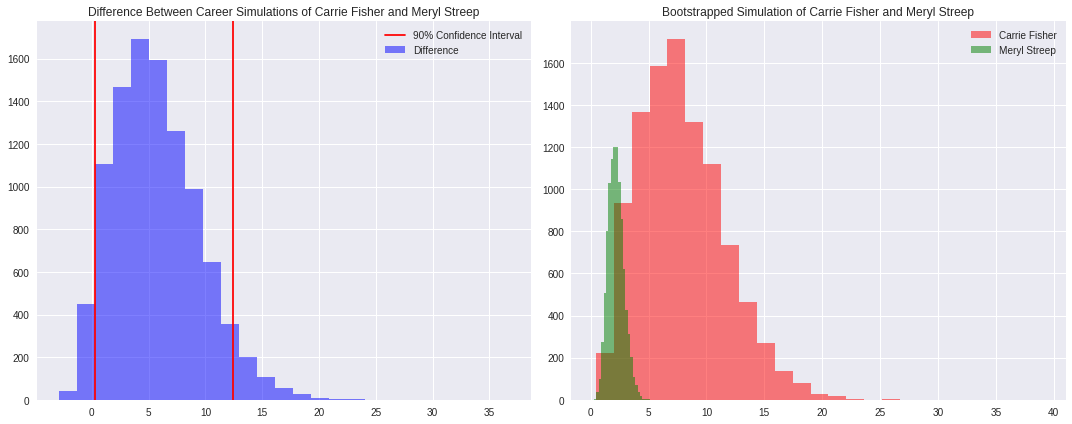

In [17]:
fig, ax = plt.subplots(1,2,figsize = (15,6))
compare_actors_roi(contest_df, 'Carrie Fisher','Meryl Streep', ax)

(0, -100346484.91089742)

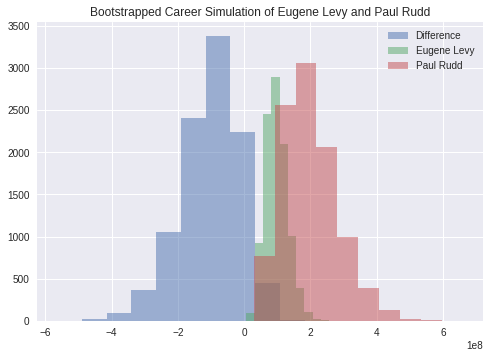

In [365]:
compare_actors_net(contest_df, 'Eugene Levy','Paul Rudd')

(0, -184684234.46823847)

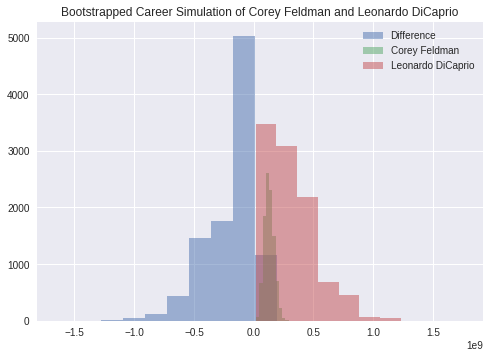

In [315]:
compare_actors_net(contest_df, 'Corey Feldman','Leonardo DiCaprio')

(0, [-6.185470332420054, 5.547649026056675])

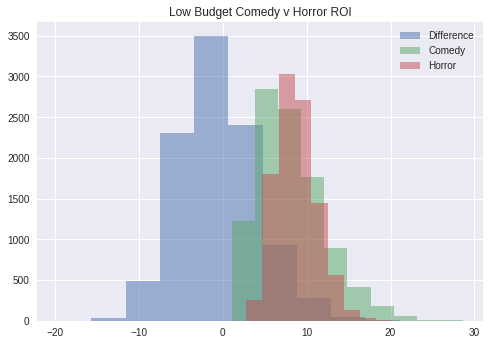

In [16]:
compare_genre_roi(contest_df.where((contest_df.adjusted_budget <= 1e7)), 'Comedy', 'Horror', graph_title = 'Low Budget Comedy v Horror ROI')

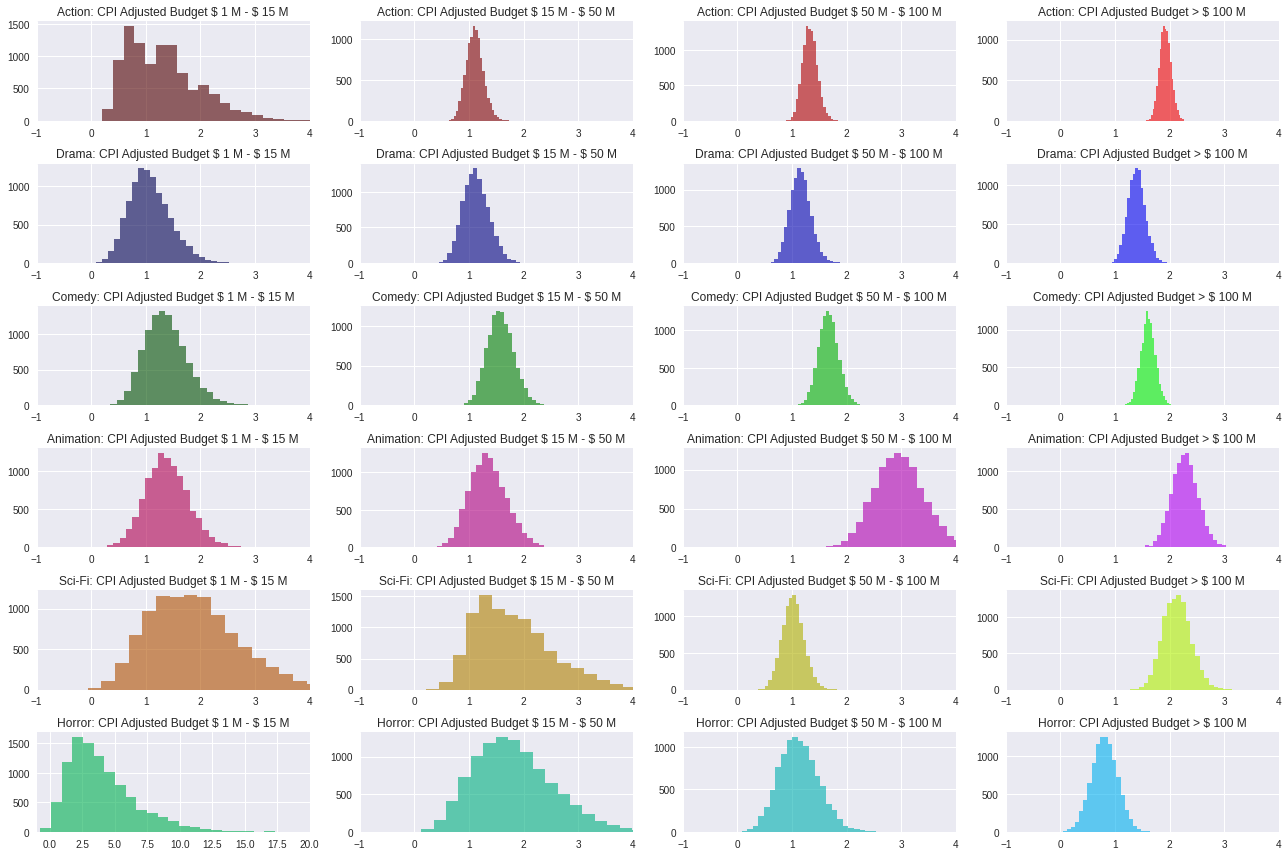

In [17]:
fig, axs = plt.subplots(6,4, figsize = (18,12))

action_axs = axs.flatten()[:4]
drama_axs = axs.flatten()[4:8]
comedy_axs = axs.flatten()[8:12]
animation_axs = axs.flatten()[12:16]
sci_fi_axs = axs.flatten()[16:20]
horror_axs = axs.flatten()[20:]

action_colors = ['#500000','#800000','#B00000','#F00000']
drama_colors = ['#000050','#000080','#0000B0','#0000F0']
comedy_colors = ['#005000','#008000','#00B000','#00F000']
animation_colors = ['#B00050','#B00080','#B000B0','#B000F0']
sci_fi_colors = ['#B05000','#B08000','#B0B000','#B0F000']
horror_colors = ['#00B050','#00B080','#00B0B0', '#00B0F0']

action_results = compare_genre_budget_class_roi(contest_df.where((contest_df.year > 1977)), 'Action', action_axs, genre_colors = action_colors, budget_buckets = [1e6, 1.5e7, 5e7, 1e8])
drama_results = compare_genre_budget_class_roi(contest_df.where((contest_df.year > 1977)), 'Drama', drama_axs, genre_colors = drama_colors, budget_buckets = [1e6, 1.5e7, 5e7, 1e8])
comedy_results = compare_genre_budget_class_roi(contest_df.where((contest_df.year > 1977)), 'Comedy', comedy_axs, genre_colors = comedy_colors, budget_buckets = [1e6, 1.5e7, 5e7, 1e8])
animation_results = compare_genre_budget_class_roi(contest_df.where((contest_df.year > 1977)), 'Animation', animation_axs, genre_colors = animation_colors, budget_buckets = [1e6, 1.5e7, 5e7, 1e8])
sci_fi_results = compare_genre_budget_class_roi(contest_df.where((contest_df.year > 1977)), 'Sci-Fi', sci_fi_axs, genre_colors = sci_fi_colors, budget_buckets = [1e6, 1.5e7, 5e7, 1e8])
horror_results = compare_genre_budget_class_roi(contest_df.where((contest_df.year > 1977)), 'Horror', horror_axs, genre_colors = horror_colors, budget_buckets = [1e6, 1.5e7, 5e7, 1e8])
plt.savefig('images/budget_group_roi.png')

### Tournament, Not optimized, uncomment if you want to run

In [255]:
tourney = np.loadtxt('Smiros_Tournament.txt', delimiter = ', ', dtype = str)
np.random.seed(42)
randomized = np.random.choice(tourney, len(tourney), replace = False)
rr_1 = list(randomized[:8])
rr_2 = list(randomized[8:16])
rr_3 = list(randomized[16:24])
rr_4 = list(randomized[24:32])
rr_5 = list(randomized[32:40])
rr_6 = list(randomized[40:48])
rr_7 = list(randomized[48:56])
rr_8 = list(randomized[56:64])
rr_9 = list(randomized[64:72])
rr_10 = list(randomized[72:80])
rr_11 = list(randomized[80:88])
rr_12 = list(randomized[88:96])
rr_13 = list(randomized[96:104])
rr_14 = list(randomized[104:112])
rr_15 = list(randomized[112:120])
rr_16 = list(randomized[120:])

In [163]:
rr_1_result #= round_robin_8(contest_df, rr_1) # DONE - MARLON BRANDO, BENEDICT CUMBERBATCH

In [165]:
rr_2_result #= round_robin_8(contest_df, rr_2) #DONE - ROBERT DOWNEY JR., MARGO ROBBIE

In [152]:
rr_3_result #= round_robin_8(contest_df, rr_3) # DONE - JOHN TRAVOLTA, JAMIE LEE CURTIS

In [155]:
rr_4_result #= round_robin_8(contest_df, rr_4) # DONE - IDRIS ELBA, ROBERT PATTINSON

In [166]:
rr_5_result #= round_robin_8(contest_df, rr_5) # DONE - KEVIN HART, JENNY SLATE

In [169]:
rr_6_result #= round_robin_8(contest_df, rr_6) # DONE - JOAQUIN PHOENIX, ROBIN WILLIAMS

In [173]:
rr_7_result #= round_robin_8(contest_df, rr_7) # DONE - PAUL RUDD, JONATHAN BANKS

In [180]:
rr_8_result #= round_robin_8(contest_df, rr_8) # DONE - SAMUEL L. JACKSON, CHRIS PRATT

In [183]:
rr_9_result #= round_robin_8(contest_df, rr_9) # DONE - EUGENE LEVY, TOM HANKS

In [198]:
rr_10_result #= round_robin_8(contest_df, rr_10) # DONE - SHIA LABEOUF, IRRFAN KHAN

In [210]:
rr_11_result #= round_robin_8(contest_df, rr_11) # DONE - KEVIN BACON, JODIE FOSTER

In [318]:
rr_12_result #= round_robin_8(contest_df, rr_12) # DONE - CHRIS HEMSWORTH, COREY FELDMAN 

['Chris Hemsworth', 'Corey Feldman']

In [235]:
rr_13_result #= round_robin_8(contest_df, rr_13) # DONE - VIN DIESEL, CARRIE FISHER

['Vin Diesel', 'Carrie Fisher']

In [253]:
rr_14_result #= round_robin_8(contest_df, rr_14) # DONE - CHADWICK BOSEMAN, WILL SMITH

['Chadwick Boseman', 'Will Smith']

In [258]:
rr_15_result #= round_robin_8(contest_df, rr_15) # DONE - JULIA ROBERTS, HARRISON FORD

['Julia Roberts', 'Harrison Ford']

In [261]:
rr_16_result #= round_robin_8(contest_df, rr_16) # DONE - RAUL JULIA, JODIE FOSTER

['Raul Julia', 'Jodie Foster']

In [320]:
qualified = rr_1_result + rr_2_result + rr_3_result + rr_4_result +\
            rr_5_result + rr_6_result + rr_7_result + rr_8_result +\
            rr_9_result + rr_10_result + rr_11_result + rr_12_result +\
            rr_13_result + rr_14_result + rr_15_result + rr_16_result

In [330]:
tournament_start = np.random.choice(qualified, len(qualified), replace = False)
round_1 = run_tournament_round(contest_df, tournament_start)
round_1

['John Travolta',
 'Vin Diesel',
 'Robert Pattinson',
 'Shia LaBeouf',
 'Inconclusive',
 'Will Smith',
 'Inconclusive',
 'Jenny Slate',
 'Tom Hanks',
 'Inconclusive',
 'Inconclusive',
 'Jodie Foster',
 'Inconclusive',
 'Kevin Bacon',
 'Jonathan Banks',
 'Carrie Fisher']

In [338]:
tournament_start

array(['John Travolta', 'Idris Elba', 'Jamie Lee Curtis', 'Vin Diesel',
       'Robert Pattinson', 'Samuel L. Jackson', 'Joaquin Phoenix',
       'Shia LaBeouf', 'Kevin Hart', 'Paul Rudd', 'Robert Downey Jr.',
       'Will Smith', 'Corey Feldman', 'Marlon Brando',
       'Benedict Cumberbatch', 'Jenny Slate', 'Tom Hanks',
       'Robin Williams', 'Margo Robbie', 'Harrison Ford',
       'Chadwick Boseman', 'Chris Hemsworth', 'Jodie Foster',
       'Eugene Levy', 'Julia Roberts', 'Chris Pratt', 'Kevin Bacon',
       'Raul Julia', 'Jodie Foster', 'Jonathan Banks', 'Carrie Fisher',
       'Irrfan Khan'], dtype='<U20')

In [333]:
round_2 = run_tournament_round(contest_df, round_1)
round_2

['Vin Diesel',
 'Robert Pattinson',
 'Will Smith',
 'Jenny Slate',
 'Tom Hanks',
 'Jodie Foster',
 'Kevin Bacon',
 'Carrie Fisher']

In [334]:
round_3 = run_tournament_round(contest_df, round_2)
round_3s

['Inconclusive', 'Jenny Slate', 'Tom Hanks', 'Carrie Fisher']

In [360]:
contest_df.select('Original_title','adjusted_budget','adjusted_worlwide_gross_income').where(contest_df.actors.rlike('Carrie Fisher')).show()

+--------------------+--------------------+------------------------------+
|      Original_title|     adjusted_budget|adjusted_worlwide_gross_income|
+--------------------+--------------------+------------------------------+
|             Shampoo|1.9368029739776954E7|          2.3923262505576208E8|
|           Star Wars| 4.728547854785478E7|          3.3347821354455442E9|
|Star Wars: Episod...| 5.690533980582524E7|          1.7364521293203883E9|
|   Under the Rainbow| 5.731573157315731E7|           5.395270236523652E7|
|Star Wars: Episod...| 8.500251004016064E7|          1.2432522147791166E9|
|The Man with One ...| 3.873605947955391E7|           2.093057217007435E7|
|Hannah and Her Si...|1.5211678832116788E7|           9.527274105839416E7|
|Appointment with ...|1.3212172442941673E7|            2114035.6720202873|
|          The 'Burbs| 3.781451612903226E7|          1.0315378158064516E8|
|When Harry Met Sa...| 3.361290322580645E7|          1.9555029129032257E8|
|     Sibling Rivalry|3.1

In [167]:
round_1_bracket_1 = list(bracket1)
round_2_bracket_1 = run_tournament_round(american_budget_df, round_1_bracket_1)

In [270]:
group_1 = ['Robert Downey Jr.', 'Eugene Levy', 'Will Smith','Kevin Bacon','Jonathan Banks','Tom Hanks','Raul Julia','Jamie Lee Curtis']
group_1_round_1 = run_tournament_round()

['Marlon Brando',
 'Benedict Cumberbatch',
 'Uma Thurman',
 'Al Pacino',
 'Sean Connery',
 'Michelle Yeoh',
 'Nicole Kidman',
 'Alfred Molina']

In [376]:
comedy_results

[[0.904, 1.893], [1.287, 1.897], [1.438, 1.897], [1.441, 1.776]]

### Annualized EDA

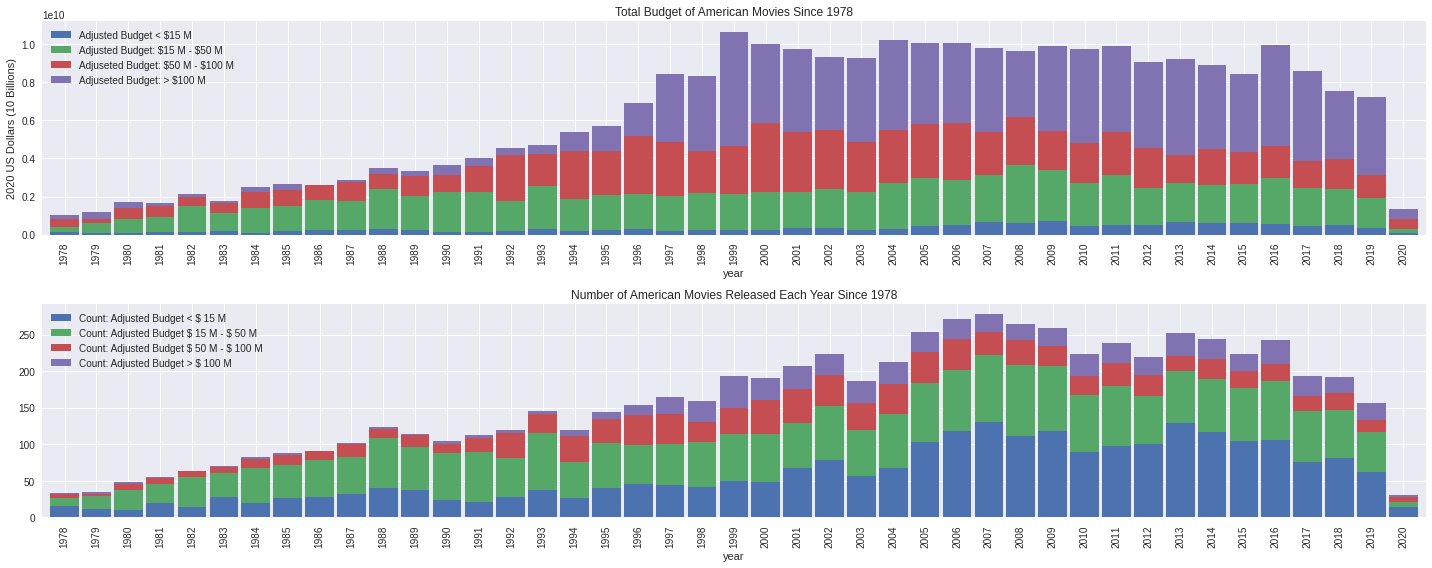

In [360]:
#def annual_percentage_budget_analysis():
annual_total_budget = american_budget_df.groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_total_gross = american_budget_df.groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()

annual_total_budget = annual_total_budget.rename(columns = {'sum(adjusted_budget)': 'Total_Adjusted_Budget'}, inplace = False)
annual_total_budget = annual_total_budget.set_index('year')
annual_total_gross = annual_total_gross.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Total_Adjusted_WorldWide_Gross_Income'}, inplace = False)
annual_total_gross = annual_total_gross.set_index('year')

annual_total_budget_small_budget = american_budget_df.where(american_budget_df.adjusted_budget < 1.5e7).groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_total_budget_small_budget = annual_total_budget_small_budget.rename(columns = {'sum(adjusted_budget)': 'Adjusted Budget < $15 M'}, inplace = False)
annual_total_budget_small_budget = annual_total_budget_small_budget.set_index('year')


annual_total_budget_mid_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7)).groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_total_budget_mid_budget = annual_total_budget_mid_budget.rename(columns = {'sum(adjusted_budget)': 'Adjusted Budget: \$15 M - \$50 M'}, inplace = False)
annual_total_budget_mid_budget = annual_total_budget_mid_budget.set_index('year')

annual_total_budget_big_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget <1e8)).groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_total_budget_big_budget = annual_total_budget_big_budget.rename(columns = {'sum(adjusted_budget)': 'Adjuseted Budget: \$50 M - \$100 M'}, inplace = False)
annual_total_budget_big_budget = annual_total_budget_big_budget.set_index('year')

annual_total_budget_huge_budget = american_budget_df.where(american_budget_df.adjusted_budget >= 1e8).groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_total_budget_huge_budget = annual_total_budget_huge_budget.rename(columns = {'sum(adjusted_budget)': 'Adjuseted Budget: > $100 M'}, inplace = False)
annual_total_budget_huge_budget = annual_total_budget_huge_budget.set_index('year')

fig, ax1 = plt.subplots(2,1)

annual_total_budget_all_budgets = annual_total_budget_small_budget.join([annual_total_budget_mid_budget, annual_total_budget_big_budget, annual_total_budget_huge_budget])
annual_total_budget_all_budgets.plot(kind="bar", width=.9, stacked = True, figsize=(20,8), ax = ax1[0], ylabel = '2020 US Dollars (10 Billions)', title = 'Total Budget of American Movies Since 1978')


movie_count_by_year_small = american_budget_df.where(american_budget_df.adjusted_budget < 1.5e7).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget < $ 15 M'})
movie_count_by_year_mid = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7)).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 15 M - \$ 50 M'})
movie_count_by_year_big = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) &(american_budget_df.adjusted_budget < 1e8)).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 50 M - \$ 100 M'})
movie_count_by_year_huge = american_budget_df.where(american_budget_df.adjusted_budget > 1e8).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget > $ 100 M'})

movie_count_by_year_all = movie_count_by_year_small.join([movie_count_by_year_mid, movie_count_by_year_big, movie_count_by_year_huge])
movie_count_by_year_all.plot(kind = "bar",stacked = True, ax = ax1[1], width = .9, title = 'Number of American Movies Released Each Year Since 1978')
plt.tight_layout()
plt.savefig('images/budget_since_78.png')


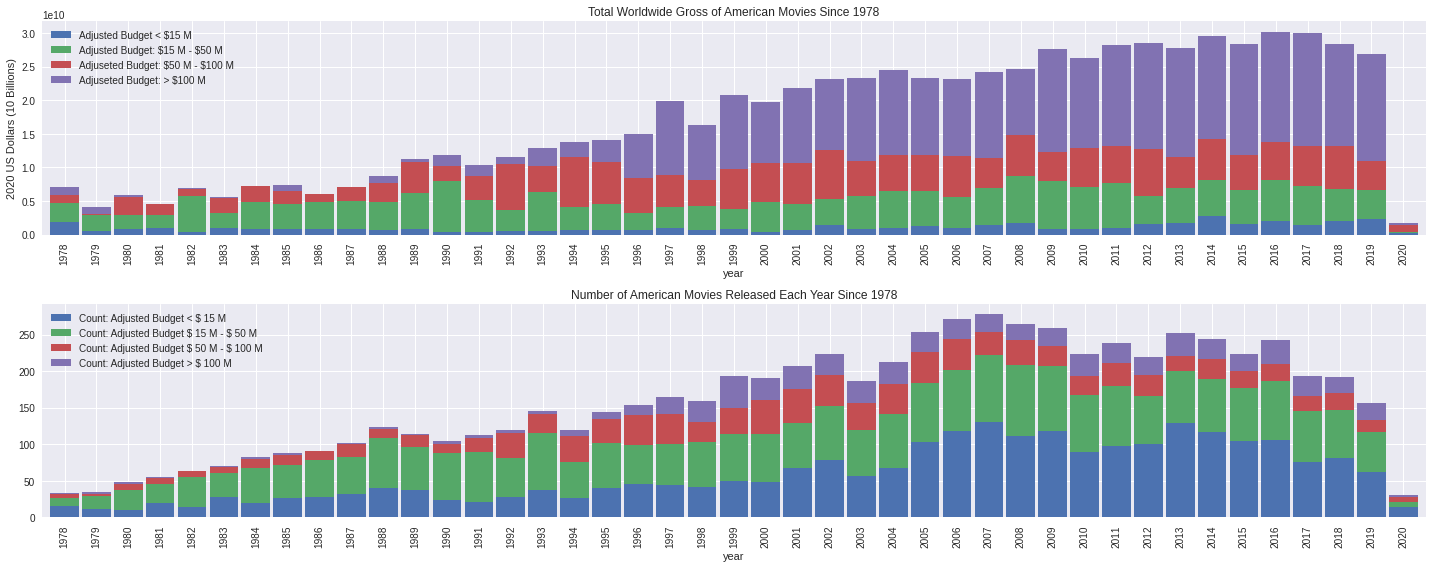

In [361]:
annual_total_gross_small_budget = american_budget_df.where(american_budget_df.adjusted_budget < 1.5e7).groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_total_gross_small_budget = annual_total_gross_small_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget < $15 M'}, inplace = False)
annual_total_gross_small_budget = annual_total_gross_small_budget.set_index('year')

annual_total_gross_mid_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7)).groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_total_gross_mid_budget = annual_total_gross_mid_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget: \$15 M - \$50 M'}, inplace = False)
annual_total_gross_mid_budget = annual_total_gross_mid_budget.set_index('year')

annual_total_gross_big_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget <1e8)).groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_total_gross_big_budget = annual_total_gross_big_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjuseted Budget: \$50 M - \$100 M'}, inplace = False)
annual_total_gross_big_budget = annual_total_gross_big_budget.set_index('year')

annual_total_gross_huge_budget = american_budget_df.where(american_budget_df.adjusted_budget >= 1e8).groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_total_gross_huge_budget = annual_total_gross_huge_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjuseted Budget: > $100 M'}, inplace = False)
annual_total_gross_huge_budget = annual_total_gross_huge_budget.set_index('year')

fig, ax1 = plt.subplots(2,1)

annual_total_gross_all_budgets = annual_total_gross_small_budget.join([annual_total_gross_mid_budget, annual_total_gross_big_budget, annual_total_gross_huge_budget])
annual_total_gross_all_budgets.plot(kind = "bar", width=.9, stacked = True, figsize=(20,8), ax = ax1[0], ylabel = '2020 US Dollars (10 Billions)',title = 'Total Worldwide Gross of American Movies Since 1978')

movie_count_by_year_small = american_budget_df.where(american_budget_df.adjusted_budget < 1.5e7).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget < $ 15 M'})
movie_count_by_year_mid = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7)).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 15 M - \$ 50 M'})
movie_count_by_year_big = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) &(american_budget_df.adjusted_budget < 1e8)).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 50 M - \$ 100 M'})
movie_count_by_year_huge = american_budget_df.where(american_budget_df.adjusted_budget > 1e8).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget > $ 100 M'})

movie_count_by_year_all = movie_count_by_year_small.join([movie_count_by_year_mid, movie_count_by_year_big, movie_count_by_year_huge])
movie_count_by_year_all.plot(kind = "bar",stacked = True,width = .9, ax = ax1[1], title = 'Number of American Movies Released Each Year Since 1978')
plt.tight_layout()


plt.savefig('images/gross_since_78.png')


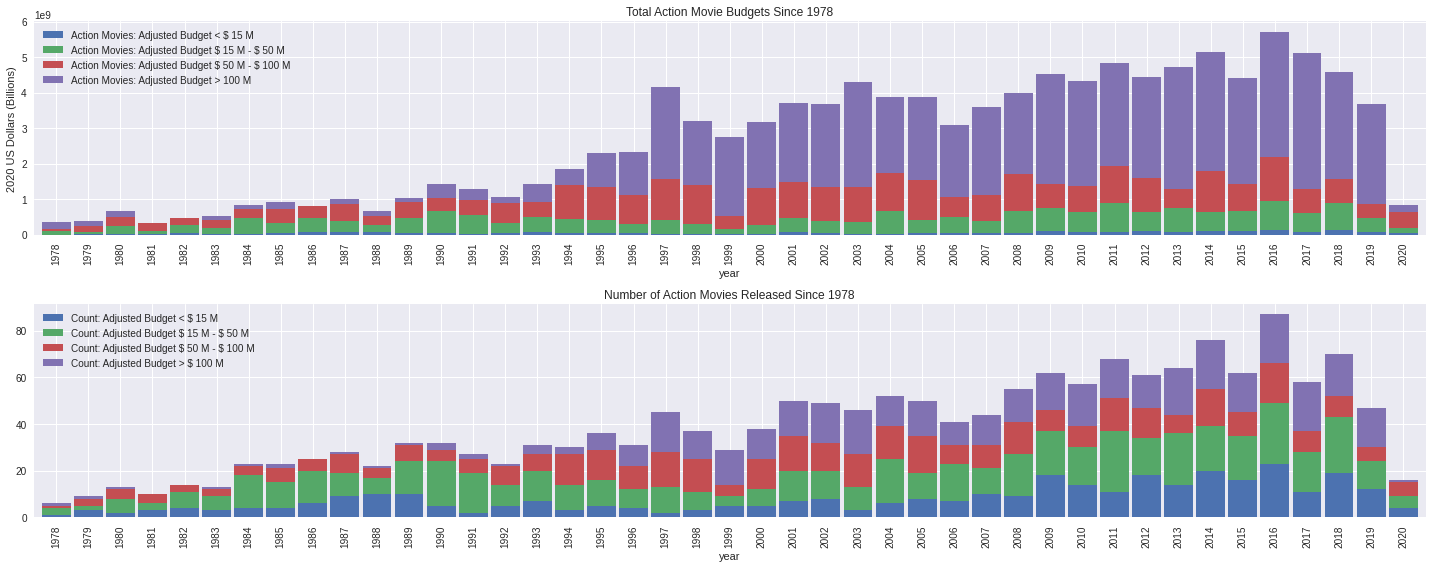

In [362]:
annual_action_budget_small_budget = american_budget_df.where((american_budget_df.adjusted_budget < 1.5e7) & (american_budget_df.genre.rlike('Action')))\
                                                     .groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_action_budget_mid_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7) & (american_budget_df.genre.rlike('Action')))\
                                                     .groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_action_budget_big_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget <1e8) & (american_budget_df.genre.rlike('Action')))\
                                                     .groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_action_budget_huge_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1e8) & (american_budget_df.genre.rlike('Action')))\
                                                     .groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()

annual_action_budget_small_budget = annual_action_budget_small_budget.rename(columns = {'sum(adjusted_budget)': 'Action Movies: Adjusted Budget < $ 15 M'}, inplace = False)
annual_action_budget_small_budget = annual_action_budget_small_budget.set_index('year')
annual_action_budget_mid_budget = annual_action_budget_mid_budget.rename(columns = {'sum(adjusted_budget)': 'Action Movies: Adjusted Budget \$ 15 M - \$ 50 M'}, inplace = False)
annual_action_budget_mid_budget = annual_action_budget_mid_budget.set_index('year')
annual_action_budget_big_budget = annual_action_budget_big_budget.rename(columns = {'sum(adjusted_budget)': 'Action Movies: Adjusted Budget \$ 50 M - \$ 100 M'}, inplace = False)
annual_action_budget_big_budget = annual_action_budget_big_budget.set_index('year')
annual_action_budget_huge_budget = annual_action_budget_huge_budget.rename(columns = {'sum(adjusted_budget)': 'Action Movies: Adjusted Budget > 100 M'}, inplace = False)
annual_action_budget_huge_budget = annual_action_budget_huge_budget.set_index('year')

fig, ax = plt.subplots(2,1)

annual_action_budget_all_budgets = annual_action_budget_small_budget.join([annual_action_budget_mid_budget, annual_action_budget_big_budget, annual_action_budget_huge_budget])
annual_action_budget_all_budgets.plot(kind="bar", width=.9, stacked = True, figsize=(20,8), ax = ax[0], title = 'Total Action Movie Budgets Since 1978', ylabel = '2020 US Dollars (Billions)')

action_movie_count_by_year_small = american_budget_df.where((american_budget_df.adjusted_budget < 1.5e7) & (american_budget_df.genre.rlike('Action'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget < $ 15 M'})
action_movie_count_by_year_mid = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7)& (american_budget_df.genre.rlike('Action'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 15 M - \$ 50 M'})
action_movie_count_by_year_big = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget < 1e8) & (american_budget_df.genre.rlike('Action'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 50 M - \$ 100 M'})
action_movie_count_by_year_huge = american_budget_df.where((american_budget_df.adjusted_budget >= 1e8) & (american_budget_df.genre.rlike('Action'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget > $ 100 M'})

action_movie_count_by_year_all = action_movie_count_by_year_small.join([action_movie_count_by_year_mid, action_movie_count_by_year_big, action_movie_count_by_year_huge])
action_movie_count_by_year_all.plot(kind= "bar",stacked = True, ax = ax[1], width = .9, title = 'Number of Action Movies Released Since 1978')
plt.tight_layout()

plt.savefig('images/action_budget_since_78.png')

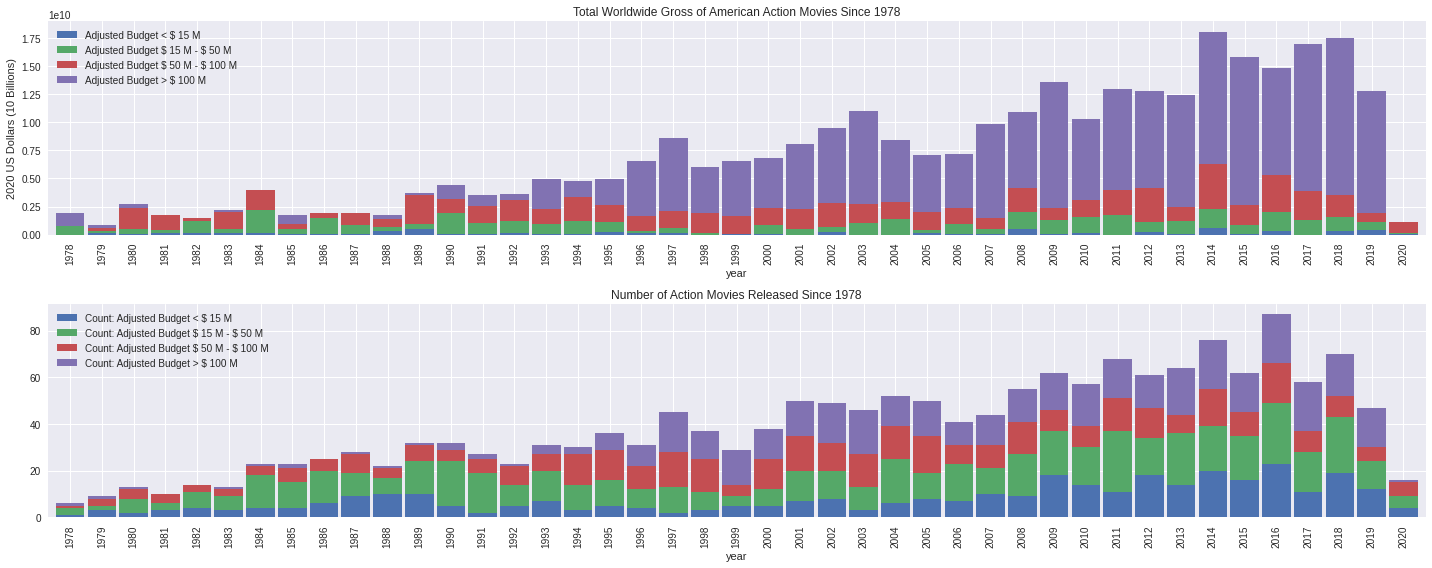

In [363]:
annual_action_gross_small_budget = american_budget_df.where((american_budget_df.adjusted_budget < 1.5e7) & (american_budget_df.genre.rlike('Action')))\
                                                     .groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_action_gross_mid_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7) & (american_budget_df.genre.rlike('Action')))\
                                                     .groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_action_gross_big_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget < 1e8) & (american_budget_df.genre.rlike('Action')))\
                                                     .groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_action_gross_huge_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1e8) & (american_budget_df.genre.rlike('Action')))\
                                                     .groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()

annual_action_gross_small_budget = annual_action_gross_small_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget < $ 15 M'}, inplace = False)
annual_action_gross_small_budget = annual_action_gross_small_budget.set_index('year')
annual_action_gross_mid_budget = annual_action_gross_mid_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget \$ 15 M - \$ 50 M'}, inplace = False)
annual_action_gross_mid_budget = annual_action_gross_mid_budget.set_index('year')
annual_action_gross_big_budget = annual_action_gross_big_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget \$ 50 M - \$ 100 M'}, inplace = False)
annual_action_gross_big_budget = annual_action_gross_big_budget.set_index('year')
annual_action_gross_huge_budget = annual_action_gross_huge_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget > $ 100 M'}, inplace = False)
annual_action_gross_huge_budget = annual_action_gross_huge_budget.set_index('year')

fig, ax = plt.subplots(2,1)

annual_action_gross_all_budgets = annual_action_gross_small_budget.join([annual_action_gross_mid_budget, annual_action_gross_big_budget, annual_action_gross_huge_budget])
annual_action_gross_all_budgets.plot(kind="bar", stacked = True, ax = ax[0], width=.9, figsize=(20,8), ylabel = '2020 US Dollars (10 Billions)', title = 'Total Worldwide Gross of American Action Movies Since 1978')

action_movie_count_by_year_small = american_budget_df.where((american_budget_df.adjusted_budget < 1.5e7) & (american_budget_df.genre.rlike('Action'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget < $ 15 M'})
action_movie_count_by_year_mid = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7)& (american_budget_df.genre.rlike('Action'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 15 M - \$ 50 M'})
action_movie_count_by_year_big = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget < 1e8) & (american_budget_df.genre.rlike('Action'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 50 M - \$ 100 M'})
action_movie_count_by_year_huge = american_budget_df.where((american_budget_df.adjusted_budget >= 1e8) & (american_budget_df.genre.rlike('Action'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget > $ 100 M'})

action_movie_count_by_year_all = action_movie_count_by_year_small.join([action_movie_count_by_year_mid, action_movie_count_by_year_big, action_movie_count_by_year_huge])
action_movie_count_by_year_all.plot(kind= "bar",stacked = True, ax = ax[1], width = .9, title = 'Number of Action Movies Released Since 1978')
plt.tight_layout()
plt.savefig('images/action_gross_since_78.png')

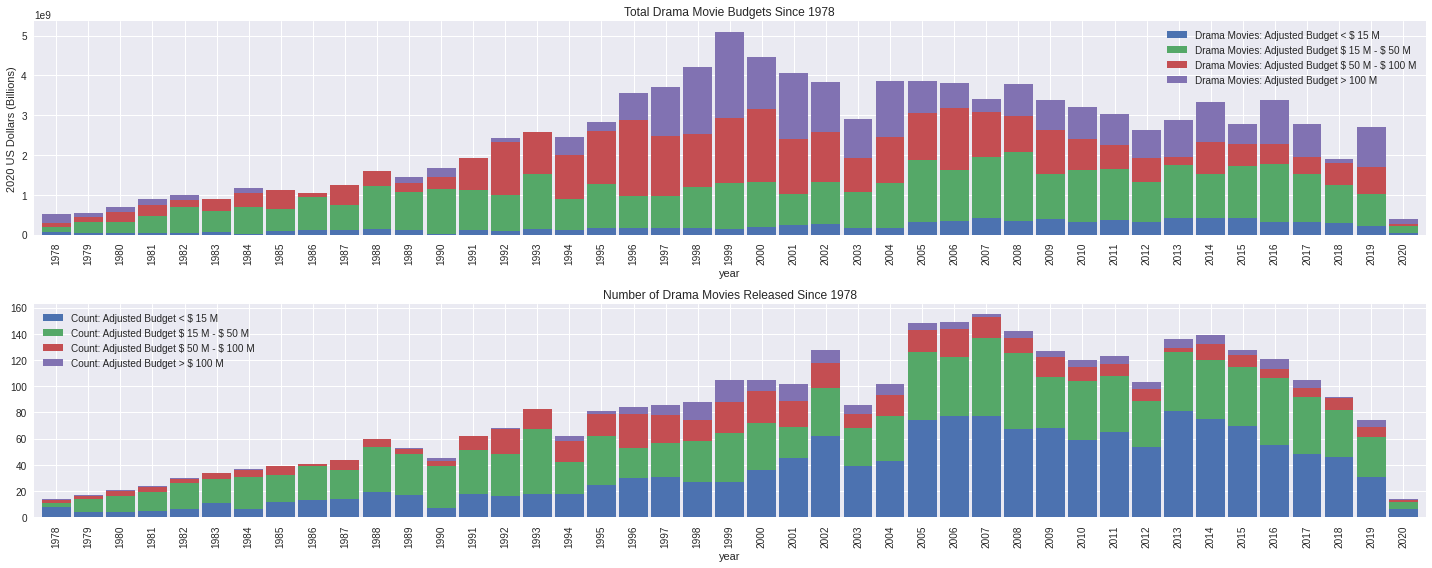

In [364]:
annual_drama_budget_small_budget = american_budget_df.where((american_budget_df.adjusted_budget < 1.5e7) & (american_budget_df.genre.rlike('Drama')))\
                                                     .groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_drama_budget_mid_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7) & (american_budget_df.genre.rlike('Drama')))\
                                                     .groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_drama_budget_big_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget <1e8) & (american_budget_df.genre.rlike('Drama')))\
                                                     .groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()
annual_drama_budget_huge_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1e8) & (american_budget_df.genre.rlike('Drama')))\
                                                     .groupBy('year').sum('adjusted_budget').orderBy('year').toPandas()

annual_drama_budget_small_budget = annual_drama_budget_small_budget.rename(columns = {'sum(adjusted_budget)': 'Drama Movies: Adjusted Budget < $ 15 M'}, inplace = False)
annual_drama_budget_small_budget = annual_drama_budget_small_budget.set_index('year')
annual_drama_budget_mid_budget = annual_drama_budget_mid_budget.rename(columns = {'sum(adjusted_budget)': 'Drama Movies: Adjusted Budget \$ 15 M - \$ 50 M'}, inplace = False)
annual_drama_budget_mid_budget = annual_drama_budget_mid_budget.set_index('year')
annual_drama_budget_big_budget = annual_drama_budget_big_budget.rename(columns = {'sum(adjusted_budget)': 'Drama Movies: Adjusted Budget \$ 50 M - \$ 100 M'}, inplace = False)
annual_drama_budget_big_budget = annual_drama_budget_big_budget.set_index('year')
annual_drama_budget_huge_budget = annual_drama_budget_huge_budget.rename(columns = {'sum(adjusted_budget)': 'Drama Movies: Adjusted Budget > 100 M'}, inplace = False)
annual_drama_budget_huge_budget = annual_drama_budget_huge_budget.set_index('year')

fig, ax = plt.subplots(2,1)

annual_drama_budget_all_budgets = annual_drama_budget_small_budget.join([annual_drama_budget_mid_budget, annual_drama_budget_big_budget, annual_drama_budget_huge_budget])
annual_drama_budget_all_budgets.plot(kind="bar", width=.9, stacked = True, figsize=(20,8), ax = ax[0], title = 'Total Drama Movie Budgets Since 1978', ylabel = '2020 US Dollars (Billions)')

drama_movie_count_by_year_small = american_budget_df.where((american_budget_df.adjusted_budget < 1.5e7) & (american_budget_df.genre.rlike('Drama'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget < $ 15 M'})
drama_movie_count_by_year_mid = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7)& (american_budget_df.genre.rlike('Drama'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 15 M - \$ 50 M'})
drama_movie_count_by_year_big = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget < 1e8) & (american_budget_df.genre.rlike('Drama'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 50 M - \$ 100 M'})
drama_movie_count_by_year_huge = american_budget_df.where((american_budget_df.adjusted_budget >= 1e8) & (american_budget_df.genre.rlike('Drama'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget > $ 100 M'})

drama_movie_count_by_year_all = drama_movie_count_by_year_small.join([drama_movie_count_by_year_mid, drama_movie_count_by_year_big, drama_movie_count_by_year_huge])
drama_movie_count_by_year_all.plot(kind= "bar",stacked = True, ax = ax[1], width = .9, title = 'Number of Drama Movies Released Since 1978')
plt.tight_layout()

plt.savefig('images/drama_budget_since_78.png')

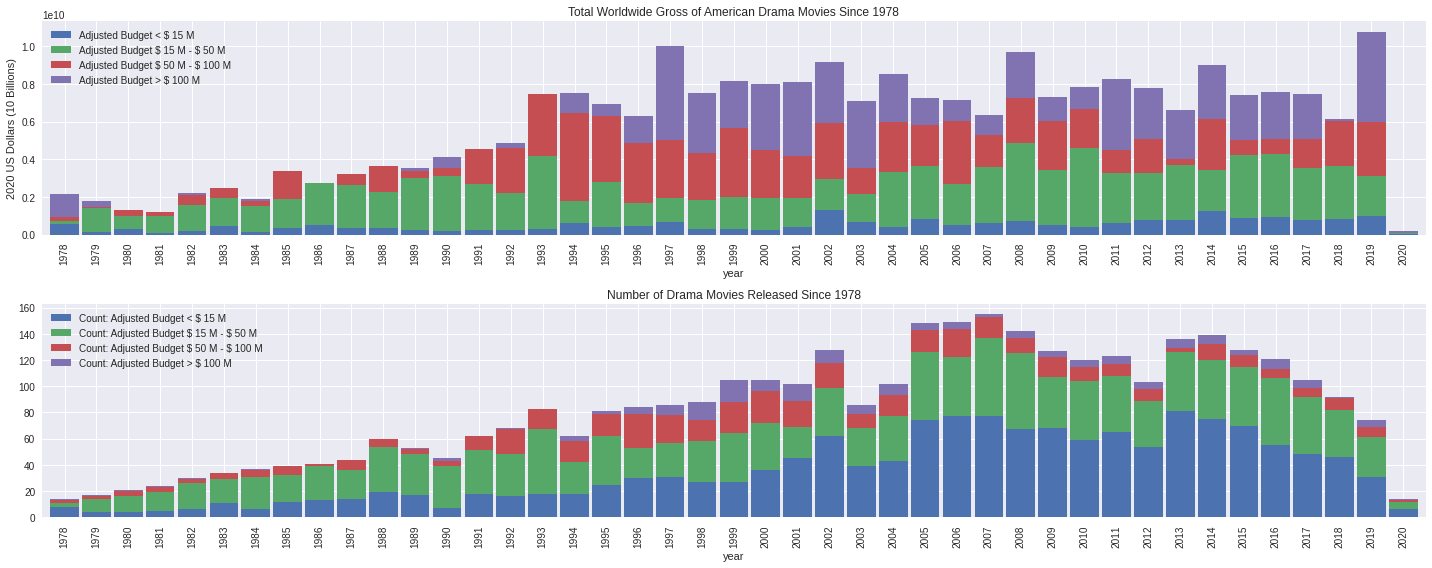

In [365]:
annual_drama_gross_small_budget = american_budget_df.where((american_budget_df.adjusted_budget < 1.5e7) & (american_budget_df.genre.rlike('Drama')))\
                                                     .groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_drama_gross_mid_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7) & (american_budget_df.genre.rlike('Drama')))\
                                                     .groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_drama_gross_big_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget < 1e8) & (american_budget_df.genre.rlike('Drama')))\
                                                     .groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()
annual_drama_gross_huge_budget = american_budget_df.where((american_budget_df.adjusted_budget >= 1e8) & (american_budget_df.genre.rlike('Drama')))\
                                                     .groupBy('year').sum('adjusted_worlwide_gross_income').orderBy('year').toPandas()

annual_drama_gross_small_budget = annual_drama_gross_small_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget < $ 15 M'}, inplace = False)
annual_drama_gross_small_budget = annual_drama_gross_small_budget.set_index('year')
annual_drama_gross_mid_budget = annual_drama_gross_mid_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget \$ 15 M - \$ 50 M'}, inplace = False)
annual_drama_gross_mid_budget = annual_drama_gross_mid_budget.set_index('year')
annual_drama_gross_big_budget = annual_drama_gross_big_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget \$ 50 M - \$ 100 M'}, inplace = False)
annual_drama_gross_big_budget = annual_drama_gross_big_budget.set_index('year')
annual_drama_gross_huge_budget = annual_drama_gross_huge_budget.rename(columns = {'sum(adjusted_worlwide_gross_income)': 'Adjusted Budget > $ 100 M'}, inplace = False)
annual_drama_gross_huge_budget = annual_drama_gross_huge_budget.set_index('year')

fig, ax = plt.subplots(2,1)

annual_drama_gross_all_budgets = annual_drama_gross_small_budget.join([annual_drama_gross_mid_budget, annual_drama_gross_big_budget, annual_drama_gross_huge_budget])
annual_drama_gross_all_budgets.plot(kind="bar", stacked = True, ax = ax[0], width=.9, figsize=(20,8), ylabel = '2020 US Dollars (10 Billions)', title = 'Total Worldwide Gross of American Drama Movies Since 1978')

drama_movie_count_by_year_small = american_budget_df.where((american_budget_df.adjusted_budget < 1.5e7) & (american_budget_df.genre.rlike('Drama'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget < $ 15 M'})
drama_movie_count_by_year_mid = american_budget_df.where((american_budget_df.adjusted_budget >= 1.5e7) & (american_budget_df.adjusted_budget < 5e7)& (american_budget_df.genre.rlike('Drama'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 15 M - \$ 50 M'})
drama_movie_count_by_year_big = american_budget_df.where((american_budget_df.adjusted_budget >= 5e7) & (american_budget_df.adjusted_budget < 1e8) & (american_budget_df.genre.rlike('Drama'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget \$ 50 M - \$ 100 M'})
drama_movie_count_by_year_huge = american_budget_df.where((american_budget_df.adjusted_budget >= 1e8) & (american_budget_df.genre.rlike('Drama'))).groupBy('year')\
                                                .count().orderBy('year').toPandas().set_index('year')\
                                                .rename(columns = {'count': 'Count: Adjusted Budget > $ 100 M'})

drama_movie_count_by_year_all = drama_movie_count_by_year_small.join([drama_movie_count_by_year_mid, drama_movie_count_by_year_big, drama_movie_count_by_year_huge])
drama_movie_count_by_year_all.plot(kind= "bar",stacked = True, ax = ax[1], width = .9, title = 'Number of Drama Movies Released Since 1978')
plt.tight_layout()
plt.savefig('images/drama_gross_since_78.png')